In [1]:
import os
import glob
import re 
from xml.dom import minidom
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import OrderedDict
from itertools import islice

# read the data

In [2]:
os.system('tar -xvf  ./data/OpenI/NLMCXR_reports.tgz -C ./data/OpenI/')

0

In [3]:
allFiles = glob.glob(f'./data/**/*.xml', recursive=True)

In [4]:
len(allFiles)

3955

# Convert XML to csv

In [5]:
def getfilename(xml_file):
    x = re.search("[ \w-]+?(?=\.)", xml_file)
    return x.group()

def get_report(xml_file):
    #get radiology report text
    data = {}
    mydoc = minidom.parse(xml_file)
    elements = mydoc.getElementsByTagName('AbstractText')
    for element in elements:
        txt = np.nan
        if element.firstChild != None:
            if element.firstChild.data == "None.":
                txt = np.nan
            else:
                txt = element.firstChild.data
        data[element.attributes['Label'].value] = txt
        
    return data

def get_labels(xml_file):
    data = {}
    mydoc = minidom.parse(xml_file)
    elements = mydoc.getElementsByTagName('major')
    txt = []
    for element in elements:
        if element.firstChild != None:
            txt.append(element.firstChild.data)
    if len(txt) == 0:
        txt = np.nan
    data['expert_labels'] = txt
    
    elements = mydoc.getElementsByTagName('automatic')
    txt = []
    for element in elements:
        if element.firstChild != None:
            txt.append(element.firstChild.data)
    if len(txt) == 0:
        txt = np.nan
    data['manual_labels'] = txt
    
    return data

def convert_xml2csv(allFiles):
    columns = ["fileNo", "COMPARISON", "INDICATION", "FINDINGS", "IMPRESSION", "expert_labels", "manual_labels"]
    xml_df = pd.DataFrame(columns = columns)
    for xml_file in tqdm(allFiles):
#         print(xml_file)
        row = {}
        row['fileNo'] = getfilename(xml_file)

        reportDic = get_report(xml_file)
        labelsDic = get_labels(xml_file)

        row = {**row ,**reportDic, **labelsDic}
        xml_df = xml_df.append(row,ignore_index=True)
    return xml_df

xml_df = convert_xml2csv(allFiles)
xml_df.head()

100%|██████████| 3955/3955 [00:35<00:00, 111.09it/s]


,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,manual_labels
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[normal],NaN
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[normal],NaN
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[normal],NaN
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",NaN
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[normal],NaN


# Some stats


In [6]:
print("Total No. of reports: ", len(xml_df) )

Total No. of reports:  3955


In [7]:
xml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3955 entries, 0 to 3954
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   fileNo         3955 non-null   object
 1   COMPARISON     2507 non-null   object
 2   INDICATION     3865 non-null   object
 3   FINDINGS       3425 non-null   object
 4   IMPRESSION     3921 non-null   object
 5   expert_labels  3955 non-null   object
 6   manual_labels  2182 non-null   object
dtypes: object(7)
memory usage: 216.4+ KB


In [8]:
xml_df['expert_labels']

0                                                [normal]
1                                                [normal]
2                                                [normal]
3       [Cardiac Shadow/enlarged/borderline, Mediastin...
4                                                [normal]
                              ...                        
3950    [Pulmonary Congestion, Pulmonary Edema/interst...
3951    [Opacity/lung/base/bilateral, Pulmonary Atelec...
3952                                             [normal]
3953    [Lung/hyperdistention, Pulmonary Emphysema, Pe...
3954    [Aorta/tortuous/mild, Lung/hyperdistention, Op...
Name: expert_labels, Length: 3955, dtype: object

# Add a column for Noraml or not normal expert labels (NormalLabel)

In [9]:
NaN = np.nan
xml_df['NormalLabel'] = NaN

In [10]:
xml_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,manual_labels,NormalLabel
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[normal],NaN,NaN
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[normal],NaN,NaN
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[normal],NaN,NaN
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",NaN,NaN
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[normal],NaN,NaN


In [11]:
xml_df['NormalLabel'] = xml_df.apply(lambda row: 1 if row['expert_labels'][0] == 'normal'\
                      else 0 , axis=1)
xml_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,manual_labels,NormalLabel
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[normal],NaN,1
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[normal],NaN,1
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[normal],NaN,1
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",NaN,0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[normal],NaN,1


In [12]:
xml_df['NormalLabel'].value_counts()

0    2564
1    1391
Name: NormalLabel, dtype: int64

# Export the csv file

In [13]:
xml_df.to_csv('data/OpenI.csv', index=False)

In [14]:
################# remove the unziped data #################
os.system('rm -rf ./data/OpenI/ecgen-radiology')

0

# Import the csv file


In [15]:
# xml_df = pd.read_csv("data/OpenI.csv")

# Length Distributions of Impression and Findings

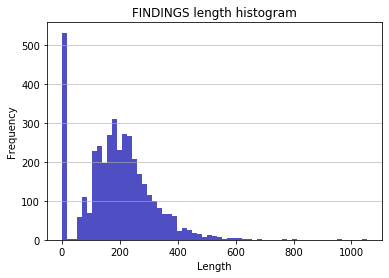

In [16]:
##############Finding#############
finding_lens = []
for finding in xml_df['FINDINGS']:
    length = 0
    if finding is not np.nan:
#         print(finding)
        length = len(finding)
    finding_lens.append(length)

n, bins, patches = plt.hist(x=finding_lens, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('FINDINGS length histogram')

maxfreq = n.max()
plt.grid(axis='y', alpha=0.75)

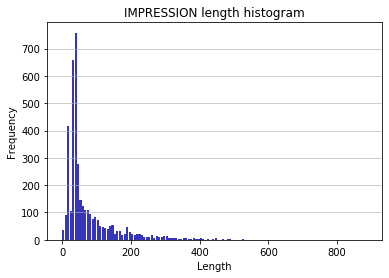

In [17]:
##############Finding#############
impression_lens = []
for impression in xml_df['IMPRESSION']:
    length = 0
    if impression is not np.nan:
        length = len(impression)
    impression_lens.append(length)

n, bins, patches = plt.hist(x=impression_lens, bins='auto', color='#0504aa',
                            alpha=0.8, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('IMPRESSION length histogram')

maxfreq = n.max()
plt.grid(axis='y', alpha=0.75)

# Notes on OpenI Labels 
(From the paper appendix A)
* Code the “normal chest” reports as “Normal” and assign no other codes to these reports

**Vocabulary:**
* Use MeSH as the primary vocabulary and add RadLex terms as needed.

The terms are grouped as follows:
*   Disorder: terms referring to an illness or anomaly of an anatomical part.
*	Objects: terms referring to medical and non-medical foreign bodies.
*	Anatomy: any term that refers to a part of the human body.
*	Signs: imaging observations such as density, opacity or consolidation.
*	Attributes: terms defining characteristics of an object or a disease. 

**ANNOTATION RULES:**    
The codes consist of the headings and subheadings.  The headings are a Disorder, an Anatomical structure, an Object or a Sign.The Sign and Anatomy terms can serve both as the headings and subheadings. The terms are post-coordinated and separated by slashes, similar to MEDLINE indexing.

*	Each code can only include one Disorder, and as many distinct subheadings as included in the report. 
*	An attribute cannot be a heading, and cannot stand alone (with the exception of Image Quality/Unsatisfactory).
*	A Disorder can be followed by an Anatomical site when the name of the disease does not include the affected organ. 
    *	Pneumonia/upper lobe/right (correct)
        *	The anatomical site is included in the disease name: pneumonia
    *	Pneumonia/lung/upper lobe/right (incorrect) 
        *	The term pneumonia refers to lung therefore the lung is not required; it is redundant.
    *	Opacity/lung/base/right (correct)
    *	Opacity/base/right (incorrect)
        *	The term lung is required; neither opacity nor base gives a clear indication of the anatomical location of the finding.
*	When the report contains two or more related terms, use the most specific term. Make sure the more specific term is hierarchically related to the more general term in the controlled vocabulary. 

**Negation:**    
Do not annotate negated terms. In the following examples, tuberculosis and cardiomegaly should not be coded:
*	no signs of tuberculosis in the present study
*	Heart is not significantly enlarged

**Uncertainty:**    
Do not annotate inconclusive findings introduced by the following terms:
*	suggesting
*	favoring
*	concerning for
*	maybe
*	could be
*	possibly
*	and/or
*	may represent
*	presumably
*	considerations may represent
*	differential diagnosis 
*	difficult to exclude
*	cannot exclude 
*	questionable 
*	subtle

**Adverbs of certainty:**     
Annotate terms introduced by adverbs of certainty and their equivalents that indicate presence of a disease or finding. Examples of these triggers include:
*	probably
*	consistent with
*	likely
*	compatible
*	most suggestive



# CheXpert Labels:
* No Finding 
* Enlarged Cardiom. 
* Cardiomegaly 
* Lung Lesion 
* Lung Opacity 
* Edema 
* Consolidation 
* Pneumonia 
* Atelectasis 
* Pneumothorax 
* Pleural Effusion 
* Pleural Other 
* Fracture 
* Support Devices 

# Grouping the labels

In [18]:
def plot_Barchart_top_n_labels(n=20):
    expert_labels = []
    for labels in xml_df['expert_labels']:
        for label in labels:
            expert_labels.append(label)

    label_counts = Counter(expert_labels)

    sorted_label_counts = OrderedDict(sorted(label_counts.items(), key=lambda x: x[1], reverse=True))
    
    unique_labels = sorted_label_counts.keys()
    print("Total No. of Unique labels:",len(unique_labels))
    
    sliced = islice(sorted_label_counts.items(), n)  
    sliced_o = OrderedDict(sliced)

    df = pd.DataFrame.from_dict(sliced_o, orient='index')
    df.plot(kind='bar', title = "Top "+str(n)+" ranked expert labels")
    return unique_labels

Total No. of Unique labels: 1719


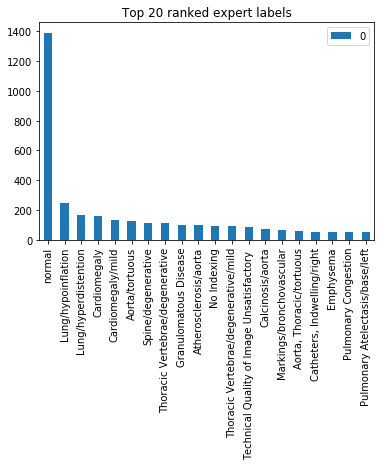

In [19]:
#********************Original OpenI dataset ****************
unique_labels = plot_Barchart_top_n_labels(20)

In [20]:
def find_similar_disorders(disroder,unique_labels):
    similar_disorders = []
    for label in unique_labels:
        match = re.search(".*"+disorder+".*", label)
        if match is not None:
            similar_disorders.append(match.group())
            print(match.group())
    return similar_disorders
def update_row(row,similar_disorders,disorder):
#     print("Before:", row)
    new_label_list = []
    for item in row:
        if item in similar_disorders:
            new_label_list.append(disorder)
        else:
            new_label_list.append(item)
#     print("After:",new_label_list)
    return new_label_list

def update_labels(similar_disorders, disorder):
    print("Updating similar labels to :", disorder)
    xml_df['expert_labels'] = xml_df.apply(lambda row: update_row(row['expert_labels'],similar_disorders,disorder), axis=1)

Pneumonia/lower lobe/right
Pneumonia/upper lobe/right
Pneumonia/lower lobe/left
Pneumonia
Pneumonia/middle lobe/right
Pneumonia/upper lobe/left
Pneumonia/upper lobe/left/round
Pneumonia/base/bilateral/patchy
Pneumonia/right/focal/multiple
Pneumonia/lower lobe/right/mild
Pneumonia/base/left
Pneumonia/lower lobe/right/anterior
Pneumonia/base/bilateral
Pneumonia/focal/multiple
Pneumonia/multilobar
Updating similar labels to : Pneumonia

Total No. of Unique labels: 1705


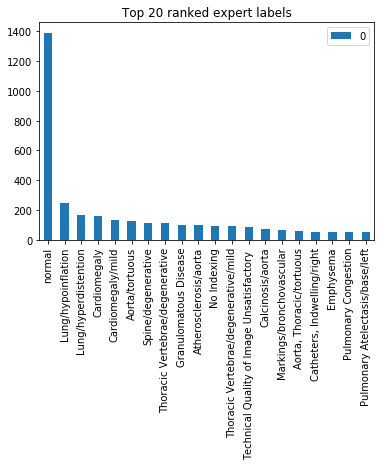

In [21]:
#**********************Pneumonia*********************
disorder = "Pneumonia"
similar_disorders = find_similar_disorders(disorder,unique_labels)
update_labels(similar_disorders, disorder)
print()
unique_labels = plot_Barchart_top_n_labels(20)

Fractures, Bone/ribs/left/healed
Fractures, Bone/thoracic vertebrae
Fractures, Bone/ribs/right
Fractures, Bone/ribs/left/multiple/healed
Fractures, Bone/ribs/bilateral/multiple/healed
Fractures, Bone/ribs/right/multiple/healed
Fractures, Bone/ribs/right/healed
Fractures, Bone/sternum
Fractures, Bone/lumbar vertebrae
Fractures, Bone/humerus/right
Fractures, Bone/ribs/healed
Fractures, Bone/clavicle/left/healed
Fractures, Bone/ribs/left/anterior/multiple
Fractures, Bone/clavicle/right
Fractures, Bone/ribs/right/multiple
Fractures, Bone/ribs/left
Fractures, Bone
Fractures, Bone/clavicle/right/healed
Fractures, Bone/ribs/left/chronic
Fractures, Bone/clavicle/right/multiple
Fractures, Bone/Thoracic Vertebrae
Fractures, Bone/ribs/right/anterior/multiple
Fractures, Bone/ribs/right/posterior/healed
Fractures, Bone/ribs/left/multiple
Fractures, Bone/lumbar vertebrae/severe
Fractures, Bone/clavicle/right/mild
Fractures, Bone/ribs/left/posterior/multiple/healed
Fractures, Bone/thoracic vertebrae/

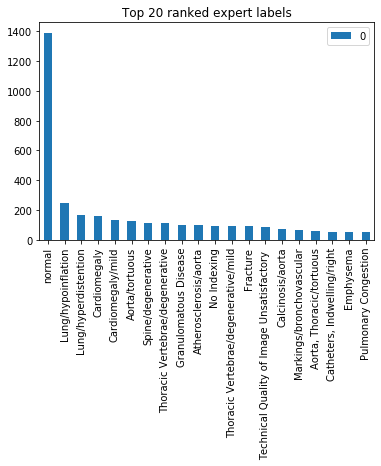

In [22]:
#**********************Fracture*********************
disorder = "Fracture"
similar_disorders = find_similar_disorders(disorder, unique_labels)
update_labels(similar_disorders, disorder)
unique_labels = plot_Barchart_top_n_labels(20)

Pulmonary Edema
Pulmonary Edema/interstitial
Pulmonary Edema/interstitial/mild
Pulmonary Edema/mild
Pulmonary Edema/lower lobe/bilateral
Pulmonary Edema/base/bilateral/interstitial
Pulmonary Edema/bilateral/interstitial/moderate
Pulmonary Edema/lower lobe/bilateral/interstitial
Pulmonary Edema/bilateral/interstitial/mild
Pulmonary Edema/base/interstitial
Pulmonary Edema/base/bilateral
Pulmonary Edema/pulmonary alveoli
Pulmonary Edema/middle lobe/bilateral
Pulmonary Edema/interstitial/diffuse
Updating similar labels to : Pulmonary Edema
Total No. of Unique labels: 1658


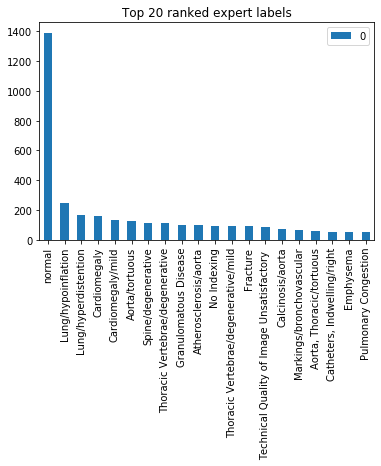

In [23]:
#**********************Pulmonary Edema*********************
disorder = "Pulmonary Edema"
similar_disorders = find_similar_disorders(disorder, unique_labels)
update_labels(similar_disorders, disorder)
unique_labels = plot_Barchart_top_n_labels(20)

Pleural Effusion/bilateral/small
Pleural Effusion/bilateral
Pleural Effusion/left/small
Pleural Effusion/right/small
Pleural Effusion/right
Pleural Effusion/left
Pleural Effusion/right/moderate
Pleural Effusion/left/large
Pleural Effusion/right/large
Pleural Effusion/posterior
Pleural Effusion/left/moderate
Pleural Effusion/base/left
Pleural Effusion/small
Pleural Effusion/base/left/small
Pleural Effusion/bilateral/moderate
Pleural Effusion/base/bilateral
Pleural Effusion/right/focal
Pleural Effusion
Pleural Effusion/bilateral/large
Pleural Effusion/bilateral/posterior/small
Pleural Effusion/right/severe
Pleural Effusion/base/right
Pleural Effusion/hilum/right
Pleural Effusion/costophrenic angle/left
Pleural Effusion/bilateral/posterior/mild
Pleural Effusion/costophrenic angle/left/mild
Pleural Effusion/lower lobe/left
Pleural Effusion/right/focal/multiple
Pleural Effusion/middle lobe/right/small
Pleural Effusion/borderline
Pleural Effusion/upper lobe/right
Pleural Effusion/bilateral/f

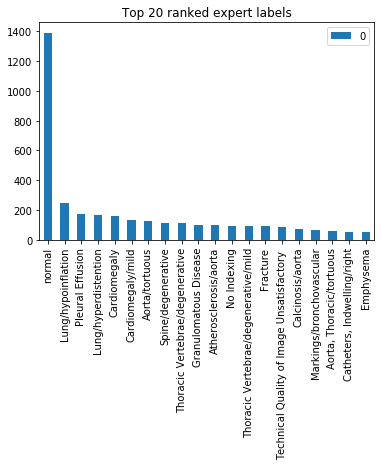

In [24]:
disorder = "Pleural Effusion"
similar_disorders = find_similar_disorders(disorder, unique_labels)
update_labels(similar_disorders, disorder)
unique_labels = plot_Barchart_top_n_labels(20)

Pulmonary Atelectasis/base/left
Pulmonary Atelectasis/base/bilateral
Pulmonary Atelectasis
Pulmonary Atelectasis/base/right
Pulmonary Atelectasis/base/bilateral/mild
Pulmonary Atelectasis/base/left/mild
Pulmonary Atelectasis/lingula
Pulmonary Atelectasis/base/right/mild
Pulmonary Atelectasis/middle lobe/right
Pulmonary Atelectasis/lower lobe/right
Pulmonary Atelectasis/lower lobe/left
Pulmonary Atelectasis/base
Pulmonary Atelectasis/upper lobe/left
Pulmonary Atelectasis/right
Pulmonary Atelectasis/left
Pulmonary Atelectasis/upper lobe/right
Pulmonary Atelectasis/bilateral
Pulmonary Atelectasis/middle lobe/right/mild
Pulmonary Atelectasis/base/bilateral/patchy
Pulmonary Atelectasis/base/left/patchy
Pulmonary Atelectasis/lingula/focal
Pulmonary Atelectasis/focal
Pulmonary Atelectasis/lower lobe/bilateral
Pulmonary Atelectasis/middle lobe/right/focal
Pulmonary Atelectasis/base/mild
Pulmonary Atelectasis/left/severe
Pulmonary Atelectasis/base/left/focal
Pulmonary Atelectasis/base/patchy
Pu

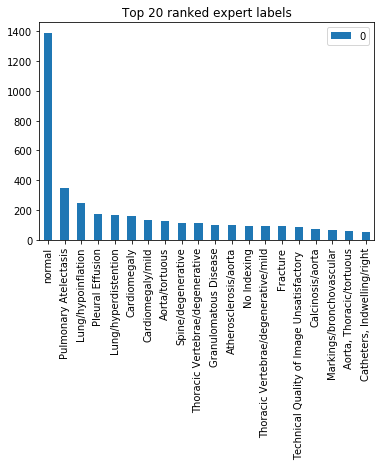

In [25]:
disorder = "Pulmonary Atelectasis"
similar_disorders = find_similar_disorders(disorder, unique_labels)
update_labels(similar_disorders, disorder)
unique_labels = plot_Barchart_top_n_labels(20)

Cardiomegaly
Cardiomegaly/mild
Cardiomegaly/borderline
Cardiomegaly/moderate
Cardiomegaly/severe
Updating similar labels to : Cardiomegaly
Total No. of Unique labels: 1558


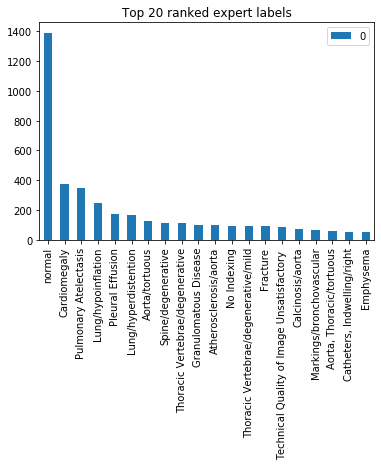

In [26]:
disorder = "Cardiomegaly"
similar_disorders = find_similar_disorders(disorder, unique_labels)
update_labels(similar_disorders, disorder)
unique_labels = plot_Barchart_top_n_labels(20)

Opacity/lung/base/left
Opacity/lung/base/bilateral
Opacity/lung/middle lobe/right
Opacity/lung/lingula
Opacity/lung/base/right
Opacity/lung/base/bilateral/streaky
Opacity/lung/lower lobe/right
Opacity/lung/base/left/streaky
Opacity/lung/base/bilateral/interstitial
Opacity/lung/bilateral/interstitial/diffuse
Opacity/lung/upper lobe/right
Opacity/lung/right
Opacity/lung/bilateral/interstitial
Opacity/lung/upper lobe/left
Opacity/lung/interstitial
Opacity/lung/base/left/mild
Opacity/lung/base/bilateral/streaky/mild
Opacity/lung/base/left/patchy
Opacity/lung/lower lobe/bilateral
Opacity/lung/apex/right
Opacity/lung/lower lobe/left
Opacity/lung/hilum/right
Opacity/lung/base/right/patchy
Opacity/lung/upper lobe/left/round
Opacity/lung/lower lobe/right/patchy
Opacity/lung/base/bilateral/mild
Opacity/lung
Opacity/lung/hilum/left
Opacity/lung/middle lobe/right/patchy
Opacity/lung/middle lobe/bilateral/interstitial
Opacity/lung/base/bilateral/multiple
Opacity/lung/upper lobe/right/focal
Opacity/

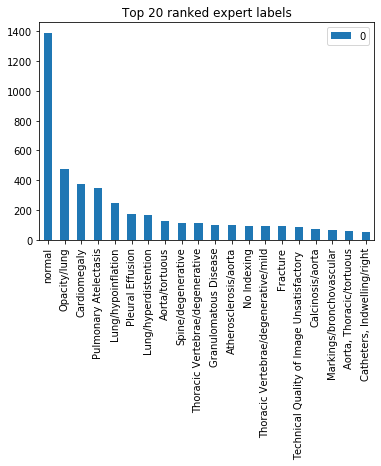

In [27]:
disorder = "Opacity/lung"
similar_disorders = find_similar_disorders(disorder, unique_labels)
update_labels(similar_disorders, disorder)
unique_labels = plot_Barchart_top_n_labels(20)

Surgical Instruments/mediastinum
Surgical Instruments
Surgical Instruments/abdomen/right
Surgical Instruments/abdomen
Surgical Instruments/right
Surgical Instruments/left
Surgical Instruments/thorax
Surgical Instruments/lung/hilum/right
Surgical Instruments/breast/left
Surgical Instruments/neck
Surgical Instruments/heart
Surgical Instruments/abdomen/multiple
Surgical Instruments/mediastinum/left
Surgical Instruments/shoulder/right
Surgical Instruments/thorax/bilateral
Surgical Instruments/cervical vertebrae
Surgical Instruments/lung/apex/left
Surgical Instruments/multiple
Surgical Instruments/bilateral
Surgical Instruments/lung/right
Surgical Instruments/abdomen/left
Surgical Instruments/thorax/right
Surgical Instruments/neck/right
Surgical Instruments/lung/hilum/left
Surgical Instruments/breast/right
Updating similar labels to : Surgical Instruments
Total No. of Unique labels: 1353


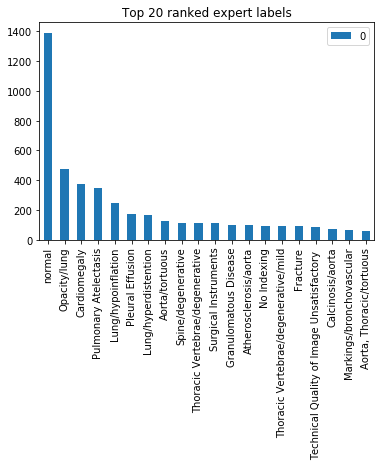

In [30]:
disorder = "Surgical Instruments"
similar_disorders = find_similar_disorders(disorder, unique_labels)
update_labels(similar_disorders, disorder)
unique_labels = plot_Barchart_top_n_labels(20)

Airspace Disease/lung/base/bilateral
Airspace Disease/lung/base/left
Airspace Disease/lung/base/right
Airspace Disease/lung/lower lobe/left
Airspace Disease/lung/lower lobe/right
Airspace Disease/lung/base/bilateral/mild
Airspace Disease/lung/middle lobe/right
Airspace Disease/lung/lower lobe/bilateral
Airspace Disease/lung/base/left/mild
Airspace Disease/lung/base/right/mild
Airspace Disease/lung/upper lobe/right
Airspace Disease/lung/middle lobe/right/patchy
Airspace Disease/lung/lower lobe/left/patchy
Airspace Disease/lung/right
Airspace Disease/lung/left
Airspace Disease/lung/base/right/focal
Airspace Disease/lung
Airspace Disease/lung/base/right/patchy
Airspace Disease/lung/bilateral
Airspace Disease/lung/lower lobe/right/patchy
Airspace Disease/lung/middle lobe/right/mild
Airspace Disease/lung/middle lobe/right/focal
Airspace Disease/lung/lingula/patchy
Airspace Disease/lung/base/right/acute
Airspace Disease/lung/streaky
Airspace Disease/lung/lingula/patchy/mild
Airspace Disease/

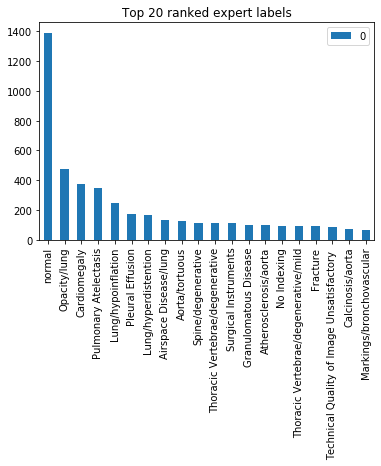

In [34]:
disorder = "Airspace Disease/lung"
similar_disorders = find_similar_disorders(disorder, unique_labels)
update_labels(similar_disorders, disorder)
unique_labels = plot_Barchart_top_n_labels(20)

In [42]:
disorder = "Thickening"
similar_disorders = find_similar_disorders(disorder, unique_labels)
# update_labels(similar_disorders, disorder)
# unique_labels = plot_Barchart_top_n_labels(20)

Thickening/pleura
Thickening/pleura/right
Thickening/pleura/apex/bilateral
Thickening/pleura/left
Thickening/pleura/apex/bilateral/mild
Thickening/pleura/bilateral
Thickening/pleura/apex/left
Thickening/pleura/apex/right
Thickening/pleura/apex/bilateral/round
Thickening/bronchovascular
Thickening/pleura/apex/left/mild
Thickening/pleura/right/mild
Thickening/right/paratracheal
Thickening/pleura/bilateral/mild
Thickening/pleura/right/focal
Thickening/lung/lower lobe/bronchi/bilateral
Thickening/lung/upper lobe/bronchi/left/scattered
Thickening/pleura/apex/right/round
Thickening/pleura/middle lobe/right/small
Thickening/pleura/mild
Thickening/bronchi
Thickening/heart ventricles
Thickening/pleura/apex/bilateral/chronic
Thickening/lung/base/bilateral/interstitial
Thickening/pleura/upper lobe/right
Thickening/lung/interstitial
Thickening/pleura/upper lobe/left
Thickening/pleura/apex/left/focal


In [35]:
unique_labels

odict_keys(['normal', 'Opacity/lung', 'Cardiomegaly', 'Pulmonary Atelectasis', 'Lung/hypoinflation', 'Pleural Effusion', 'Lung/hyperdistention', 'Airspace Disease/lung', 'Aorta/tortuous', 'Spine/degenerative', 'Thoracic Vertebrae/degenerative', 'Surgical Instruments', 'Granulomatous Disease', 'Atherosclerosis/aorta', 'No Indexing', 'Thoracic Vertebrae/degenerative/mild', 'Fracture', 'Technical Quality of Image Unsatisfactory ', 'Calcinosis/aorta', 'Markings/bronchovascular', 'Aorta, Thoracic/tortuous', 'Catheters, Indwelling/right', 'Emphysema', 'Pulmonary Congestion', 'Pulmonary Disease, Chronic Obstructive', 'Spondylosis/thoracic vertebrae', 'Spine/degenerative/mild', 'Pulmonary Edema', 'Pneumonia', 'Lung/hyperdistention/mild', 'Implanted Medical Device/left', 'Catheters, Indwelling/left', 'Diaphragm/right/elevated', 'Implanted Medical Device', 'Aorta/tortuous/mild', 'Catheters, Indwelling', 'Aorta, Thoracic/tortuous/mild', 'Lung/hypoinflation/mild', 'Cicatrix/lung/base/left', 'Diaph